## Imports

Here we are importing all the necessesary libraries and packages.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest
from google.colab import files
import statsmodels.stats.api as sms
from math import ceil
import scipy.stats as sp
from plotnine import ggplot, aes, geom_line, theme_minimal, xlab, ylab, ggtitle
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import random
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
drive.mount('/content/drive')


Mounted at /content/drive


# Introduction

In today's very competitive e-commerce landscape, businesses continuously seek ways to enhance user experience and increase conversion rates. A medium-sized online retailer, aiming to boost its sales and improve customer satisfaction, has developed a new version of their **product page**. To evaluate the effectiveness of this new design, the company has decided to conduct an `A/B test`.

The goal of this project is to analyze the results of this A/B test using both **Frequentist** and **Bayesian** approaches, utilizing different datasets for each method, to provide a detailed evaluation of the new design's impact on customer (user) behavior.

# Part 1: Frequentist Approach

## Overview

We are going to structure our project in five crucial steps:

- **Step 1: Data Cleaning**
  - We will remove any misaligned data points to maintain the integrity of the experiment.
  - We will ensure the dataset contains only unique users.

- **Step 2: Power Analysis**
  - We will determine the `minimum sample size` required to detect a significant effect.
  - We will use the baseline conversion rate, minimum detectable effect, statistical power, and significance level for our calculations.

- **Step 3: Exploratory Data Analysis (EDA)**
  - We will understand the data distribution, calculate and visualize conversion rates for both control and treatment groups.

- **Step 4: Statistical Testing**
  - We will apply a **z-test** to evaluate the significance of the differences in conversion rates between the control and treatment groups.

- **Step 5: Frequentist and Bayesian Comparison**
  - And most importantly, we will demonstrate the application of the Frequentist A/B testing method.

## Dataset

Management provided us with a comprehensive dataset to analyze the impact of the new product page design. The dataset contains 5 columns and 294,478 records:

- **user_id**: unique id of the user who came to the website
- **timestamp**: timestamp that the user came to the page
- **group**: whether the user is in the treatment group or control group
- **landing_page**: whether the user saw the old page or new page
- **converted**: whether the user converted to a paid user. 1 means converted, 0 means not converted.

In [ ]:
# set up the data path
data_path = 'PASTE_YOUR_DATA_PATH_HERE'
os.chdir(data_path)

# unzip and load the dataset
with zipfile.ZipFile(data_path + 'ab_data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('PASTE_YOUR_DATA_PATH_HERE')

# load the dataset
df_ab = pd.read_csv(data_path + 'ab_data.csv')

df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Now that the dataset is loaded, let's move on with the project.

## Exploratory Data Analysis (EDA)

In this section, we will perform a concise Exploratory Data Analysis (EDA) since the dataset is not excessively large. Our goal is to understand the basic structure of the data and identify any anomalies that need to be addressed.

In [ ]:
df_ab.shape

(294478, 5)

In [ ]:
df_ab.isna().sum()

,0
user_id,0
timestamp,0
group,0
landing_page,0
converted,0


In [ ]:
df_ab.nunique()

,0
user_id,290584
timestamp,294478
group,2
landing_page,2
converted,2


In [ ]:
pd.crosstab(df_ab['group'], df_ab['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


### Initial Finding

The crosstab result shows that there are 1,928 instances where users in the control group were shown the new page and 1,965 instances where users in the treatment group were shown the old page.

Essentially, these misaligned data points that are problematic because they contradict the experimental design, **where the control group should only see the old page, and the treatment group should only see the new page.**

Including these misaligned points would introduce bias and pretty much invalidate the results of the A/B test. Therefore, in oerder to ensure the integrity of our A/B experiment, we will remove these data points.

## Data Cleaning

In this section, we will ensure the integrity of our A/B experiment by removing any misaligned data points and making sure that each user is unique. This step is super important to maintain the validity of our test results.

In [ ]:
# removing misaligned data points using pandas methods
df_ab = df_ab[(df_ab['landing_page'] == 'new_page') & (df_ab['group'] == 'treatment') |
                  (df_ab['landing_page'] == 'old_page') & (df_ab['group'] == 'control')]


Now, let's check the results.

In [ ]:
pd.crosstab(df_ab['group'], df_ab['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


Next, let's make sure that we're using only unique users in our experiment.  

In [ ]:
df_ab.nunique()

,0
user_id,290584
timestamp,290585
group,2
landing_page,2
converted,2


In [ ]:
df_ab = df_ab.drop_duplicates(subset = 'user_id')

Awesome. Now, let's take a look at the total number of records in our dataset.

In [ ]:
df_ab.shape

(290584, 5)

In [ ]:
df_ab.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


##  Business Background

As a reminder, in our scenario, we are part of the product team at a medium-sized online e-commerce business.

Our UX designer has developed a new version of the product page, hoping it will lead to a higher `conversion rate`. Currently, the `conversion rate` stands at about **12%** on average throughout the year. The team would be satisfied with an increase of **2%**.


## Power Analysis - Determining Minimum Sample Size

Power analysis is a VERY important step in the design of our A/B test. It helps us determine the `minimum sample size` required to detect a significant effect, which allows us to make sure that our test results are reliable and valid. Without proper power analysis, we risk running tests that are too small to detect meaningful differences or unnecessarily large, wasting business resources(compute power).

The key elements we need to consider for our power analysis are:

- **Baseline Conversion Rate**: The current average conversion rate, which is 12%.

- **Minimum Detectable Effect**: The smallest change in conversion rate that we want to detect, which is 2%.

- **Statistical Power**: The probability of correctly rejecting the null hypothesis, set at 80%.

- **Significance Level (alpha)**: The probability of a Type I error, set at 5%.

In [ ]:
effect_size = sms.proportion_effectsize(0.12, 0.14)  # Calculate effect size
power = 0.80
alpha = 0.05

sample_size = sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)
sample_size = ceil(sample_size)  # Round up to the next whole number

print(f"Required sample size per group: {sample_size}")


Required sample size per group: 4433


Now, we will actually select 4433 records from each group to proceed with our analysis.

In [ ]:
required_n = 4433
seed = 18

## function to sample records from control and treatment groups
def sample_group(df, group_name, n, seed):
  return df[df['group'] == group_name].sample(n, random_state = seed)

control_group = sample_group(df_ab, 'control', required_n, seed)
treatment_group = sample_group(df_ab, 'treatment', required_n, seed)

ab_test_sample = pd.concat([control_group, treatment_group], axis = 0).reset_index(drop = True)


#let's check counts of each group in the sample

print(ab_test_sample['group'].value_counts())


group
control      4433
treatment    4433
Name: count, dtype: int64


## Calculate Conversion Rate

In this section, we calculate the conversion rates to understand how effective the new page design is compared to the old one. Conversion rate, defined as the proportion of users who completed a desired action (e.g., making a purchase or registering), is a key metric in evaluating the performance of our A/B test. By comparing the conversion rates of the control group (old page) and the treatment group (new page), we can assess whether the new design leads to higher user engagement or sales.

**Important:** While initial visual comparisons provide insights, statistical significance testing ensures that any observed differences are not due to random chance, allowing for confident, data-driven decisions on whether to adopt the new product page design.

In [ ]:
conversion_rates = ab_test_sample.groupby('group')['converted'].agg(np.mean).reset_index()
conversion_rates

<ipython-input-16-b16bc6b4102b>:1: FutureWarning: The provided callable <function mean at 0x7a1cb3913d00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


,group,converted
0,control,0.118656
1,treatment,0.123844


<Figure size 800x600 with 0 Axes>

<ipython-input-17-e50fc04973bb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='group', ylabel='converted'>

Text(0.5, 1.0, 'Conversion Rate by Group')

Text(0.5, 0, 'Group')

Text(0, 0.5, 'Conversion Rate')

Text(0, 0.12365553801037672, '0.1187')

Text(1, 0.12884389803744642, '0.1238')

(0.0, 0.14384389803744643)

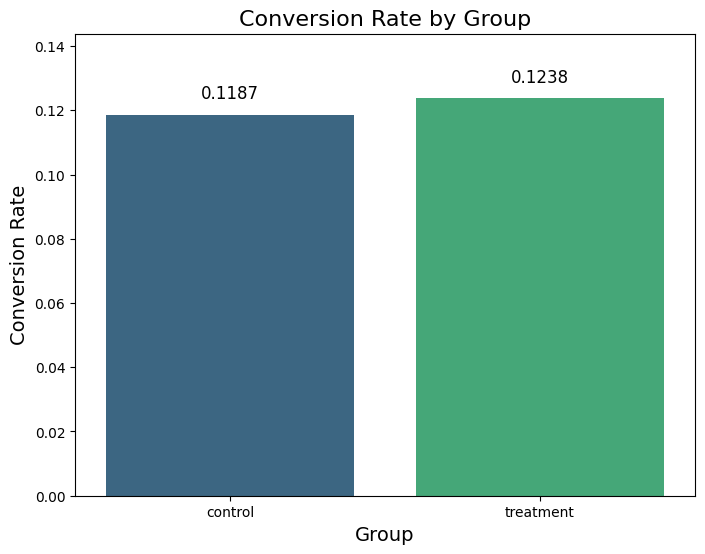

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# creating a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='group', y='converted', data=conversion_rates, palette='viridis')

# labels
plt.title('Conversion Rate by Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)

for index, row in conversion_rates.iterrows():
    plt.text(index, row['converted'] + 0.005, round(row['converted'], 4), color='black', ha="center", fontsize=12)

plt.ylim(0, max(conversion_rates['converted']) + 0.02)

plt.show()


## Test results

In this section, we will finally perform a statistical test to determine whether the observed differences in conversion rates between the control and treatment groups are statistically significant.

By using a z-test for proportions, we can formally evaluate the evidence against the null hypothesis, which states that there is no difference in conversion rates between the two groups.

In [ ]:
# separating the converstion results for control and treatment

control_results = ab_test_sample[ab_test_sample['group'] == 'control']['converted']
treatment_results = ab_test_sample[ab_test_sample['group'] == 'treatment']['converted']

# counting the number of observations in each group
n_con = control_results.count()
n_treat = treatment_results.count()
print(f'Number of observations in control group: {n_con}')
print(f'Number of observations in treatment group: {n_treat}')

Number of observations in control group: 4433
Number of observations in treatment group: 4433


In [ ]:
# calcualting the number of successes (conversions) in each group
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]
print(f'Successes: {successes}')

Successes: [526, 549]


In [ ]:
# performing the z-test
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'Z statistic: {z_stat:.2f}')
print(f'P-value: {pval:.3f}')
print(f'95% confidence interval for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'95% confidence interval for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Z statistic: -0.75
P-value: 0.454
95% confidence interval for control group: [0.109, 0.128]
95% confidence interval for treatment group: [0.114, 0.134]


In [ ]:
# interpreting the results
if pval < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the control and treatment groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the control and treatment groups.")

Fail to reject the null hypothesis: There is no significant difference between the control and treatment groups.


**There is no significant difference between the control and treatment groups.**
- This means that the new product page design does not significantly impact the conversion rate compared to the old design.

## Recommendations

- **Iterate on the New Design**:
  - Refine the new design based on user feedback and conduct further A/B tests to identify specific elements that might improve user engagement and conversion rates.

- **Analyze User Behavior**:
  - Utilize user behavior analytics to identify potential friction points in the new design and optimize these areas to enhance the overall user experience and potentially increase conversion rates.

# Manager's Note

After completing the frequentist A/B test, our manager requested a more detailed and interpretable analysis of the conversion rates for both the control and treatment groups.

**While the frequentist approach indicated no significant difference, it did not provide the probability of one variation being better than the other or account for prior knowledge.**

To address this need for better explainability, we going to adopt a Bayesian approach, which offers probabilistic interpretations and credible intervals, which is going to make the results more intuitive and informative for decision-making.

# Part 2: Bayesian A/B Tests - Bernoulli Trials with Beta Priors and Monte Carlo Simulations

To begin our Bayesian analysis, we decided to use Bernoulli trials with Beta priors, a common and widely-used method in the market for A/B testing. This approach is particularly good for conversion rate analysis, as it leverages the conjugate prior properties of the Beta distribution, allowing for straightforward updating of our beliefs with new data. And also we're employing Monte Carlo simulations, which allow us to estimate the uncertainty around our conversion rate estimates and provide intuitive probabilistic interpretations.

## Bernoulli Trials with Beta Priors and Monte Carlo Simulations

### Data Preparation

When conducting Bayesian A/B testing, you don't need to determine a minimum sample size beforehand as you do with Frequentist methods. One of the advantages of Bayesian methods is that they can continuously update the posterior distribution as new data comes in. This means you can use the whole dataset you have, and you can also add more data as it becomes available.

In [ ]:
df_ab_bayesian = df_ab[['group', 'converted']]
conversion_rates = df_ab_bayesian.groupby('group')['converted'].agg(['sum', 'count']).reset_index()
conversion_rates.columns = ['group', 'conversions', 'total']
print(conversion_rates)

       group  conversions   total
0    control        17489  145274
1  treatment        17264  145310


### Let's Adopt Bayesian Thinking

The core idea of Bayesian A/B testing is to formulate a posterior distribution for each variation. Unlike the frequentist approach, which assumes a null hypothesis and then uses the data to determine the false positive rate, the Bayesian approach allows us to directly hypothesize about the true values we are interested in, such as the conversion rate for each variation.

To do this, we need to use Bayes' Rule to construct our posterior distribution:

$$ P(H|D) = \frac{P(D|H)P(H)}{P(D)} $$

Where:

- $ H $ is the hypothesis or model (e.g., the conversion rate).
- $ D $ is the data or evidence (e.g., the observed conversions).

Here’s what each term REALLY means:

- **Posterior $ P(H|D) $**: The probability of the hypothesis being true given the observed data. **This is what we want to estimate.**
- **Likelihood $ P(D|H) $**: The probability of observing the data given that the hypothesis is true. This is similar to the p-value in frequentist statistics.
- **Prior $ P(H) $**: The initial belief about the hypothesis before seeing the data. For instance, if we have previous data or domain knowledge, we can use it to form our prior.
- **Evidence $ P(D) $**: The probability of the data being observed. This is a normalizing constant to ensure the posterior is a valid probability distribution.


### Derive the Posterior Distribution

**Likelihood:**

The likelihood function $P(D|H)$ represents the probability of observing the data given a particular hypothesis. In this case, the hypothesis $ H $ is the true conversion rate $ p $. The data $ D $ consists of clicks and conversions.

For a Bernoulli distribution, which models binary outcomes (conversion or no conversion), the likelihood of observing $ n $ conversions out of $ N $ trials is given by the Bernoulli probability mass function:

$$ P(D|H) = \prod_{i=1}^{n} p^{x_i}(1 - p)^{1 - x_i} $$

Where:
- $x_i$ is a binary indicator (1 if there is a conversion, 0 otherwise).
- $ p $ is the true conversion rate.

This simplifies to:

$$ P(D|H) = p^{\sum_{i=1}^{n} x_i} (1 - p)^{n - \sum_{i=1}^{n} x_i} $$

**Prior:**

The prior $ P(H)$ represents our initial belief about the hypothesis before observing any data. For conversion rates, we often use a Beta distribution because it is the conjugate prior for the Bernoulli distribution. The Beta distribution is defined as:

$$ P(H) = \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{B(\alpha, \beta)} $$

Where:
- $ \alpha $ and $ \beta $ are hyperparameters representing the number of successes and failures, respectively.
- $ B(\alpha, \beta) $ is the Beta function that normalizes the distribution.

**Posterior:**

The posterior distribution $ P(H|D) $ combines the prior and the likelihood to give the updated belief about the hypothesis after observing the data. Using Bayes' theorem, we get:

$$ P(H|D) \propto P(D|H) P(H) $$

Substituting the likelihood and prior, we get:

$$ P(H|D) \propto p^{\sum_{i=1}^{n} x_i} (1 - p)^{n - \sum_{i=1}^{n} x_i} \times p^{\alpha - 1} (1 - p)^{\beta - 1} $$

Combining the exponents, this simplifies to:

$$ P(H|D) \propto p^{\alpha + \sum_{i=1}^{n} x_i - 1} (1 - p)^{\beta + n - \sum_{i=1}^{n} x_i - 1} $$

This is the form of a Beta distribution:

$$ P(H|D) \propto \text{Beta}(\alpha + \text{number of conversions}, \beta + \text{number of non-conversions}) $$


Now that we understand the math, let's put it in code. We'll start by defining our priors and extracting the data needed to calculate the posterior distributions for both control and treatment groups.

 ### Defining Priors and Posterior Distribution

Again, the prior $ P(H) $ is defined as a Beta distribution:

$$ P(H) = \frac{p^{\alpha - 1} (1 - p)^{\beta - 1}}{B(\alpha, \beta)} $$

In [ ]:
# setting up our priour
alpha_prior =  1
beta_prior = 1


# extracting convertsions and total for each group
conversions_control = conversion_rates.loc[conversion_rates['group'] == 'control', 'conversions'].values[0]
total_control = conversion_rates.loc[conversion_rates['group'] == 'control', 'total'].values[0]


conversions_treatment = conversion_rates.loc[conversion_rates['group'] == 'treatment', 'conversions'].values[0]
total_treatment = conversion_rates.loc[conversion_rates['group'] == 'treatment', 'total'].values[0]


In this step, we define our priors using a Beta distribution with hyperparameters $\alpha = 1$ and $\beta = 1$, which represents a non-informative prior. We then extract the number of conversions and total observations for both the control and treatment groups.

Next, we calculate the posterior distributions for the control and treatment groups using the conjugate prior properties of the Beta distribution with the Bernoulli likelihood.

The posterior $ P(H|D) $ combines the prior and the likelihood:

$$ P(H|D) \propto p^{\alpha + \sum_{i=1}^{n} x_i - 1} (1 - p)^{\beta + n - \sum_{i=1}^{n} x_i - 1} $$

This is the form of a Beta distribution:

$$ P(H|D) \propto \text{Beta}(\alpha + \text{number of conversions}, \beta + \text{number of non-conversions}) $$

In [ ]:
# posterior distributions

posterior_control = sp.beta(alpha_prior + conversions_control, beta_prior + total_control - conversions_control)
posterior_treatment = sp.beta(alpha_prior + conversions_treatment, beta_prior + total_treatment - conversions_treatment)

By combining the prior and the likelihood, we update our belief about the true conversion rates after observing the data. The posterior distributions are Beta distributions with parameters $\alpha$ updated by the number of conversions and $\beta$ updated by the number of non-conversions.

To visualize the prior and posterior distributions, we plot the Beta distributions for both groups.

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Conversion Rate')

Text(0, 0.5, 'Density')

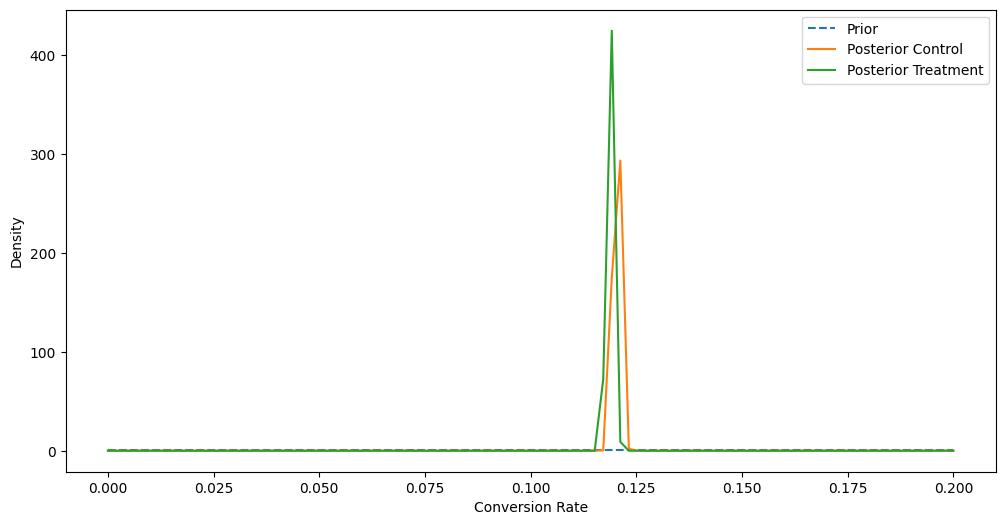

In [ ]:
# Plotting the Beta distributions
x = np.linspace(0, 0.2, 100)
y_prior = sp.beta.pdf(x, alpha_prior, beta_prior)
y_posterior_control = posterior_control.pdf(x)
y_posterior_treatment = posterior_treatment.pdf(x)

plt.figure(figsize=(12, 6))
plt.plot(x, y_prior, label='Prior', linestyle='--')
plt.plot(x, y_posterior_control, label='Posterior Control')
plt.plot(x, y_posterior_treatment, label='Posterior Treatment')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.legend()
plt.show()


### Monte Carlo Simulations

Next, we use Monte Carlo simulations to sample from the posterior distributions and estimate the probability that the treatment is better than the control, as well as calculate credible intervals for the difference in conversion rates.

In [ ]:
# num of simulations
simulations = 100000

# Monte Carlo sampling
samples_control = posterior_control.rvs(simulations)
samples_treatment = posterior_treatment.rvs(simulations)


Monte Carlo simulations allow us to draw a large number of samples from the posterior distributions, providing a strong and robust estimate of the uncertainty around our parameter estimates.

### Probability and Credible Intervals

We then calculate the probability that the treatment conversion rate is better than the control conversion rate and the credible interval for the difference in conversion rates.

In [ ]:
# calculating the probability that treatment is better than control
prob_treatment_better = (samples_treatment > samples_control).mean()
print(f'Probability that treatment is better than control: {prob_treatment_better:.4f}')

# calculating the credible interval for the difference in conversion rates
difference = samples_treatment - samples_control
credible_interval = np.percentile(difference, [2.5, 97.5])
print(f'95% credible interval for the difference in conversion rates: {credible_interval}')


Probability that treatment is better than control: 0.0951
95% credible interval for the difference in conversion rates: [-0.00392178  0.00075868]


The probability that the treatment is better than the control is simply the proportion of samples where the treatment conversion rate is higher. The credible interval provides a range of values within which we are 95% confident the true difference in conversion rates lies.

##### Result Interpretation

- This result means that there is a 9.38% probability that the treatment conversion rate is better than the control conversion rate based on the sampled data. **In other words, it is relatively unlikely that the treatment is significantly better than the control.**

- This interval suggests that the true difference in conversion rates between the treatment and control groups is likely to be between -0.00393678 and 0.00078443 with 95% confidence. Since the interval includes zero and is very narrow around zero, it indicates that there is no significant difference between the two groups.

### Implementing Stopping Criteria

Stopping criteria help determine when to end an experiment, and make sure that results are reliable without unnecessarily prolonging the test. This is important to save resources and make timely decisions which is cruial for every business.

Essentially, stopping criteria can prevent over-testing and ensure we declare a winner or conclude the test based on statistical confidence.

To implement stopping criteria, we define functions to calculate the proportion of samples and value remaining, which helps us decide whether to continue the experiment or stop.

In [ ]:
def sample_proportion(c, n, a=1, b=1, sim_size=100000):
    return np.random.beta(c + a, n - c + b, sim_size)
'''This function generates samples from a Beta distribution, representing the posterior distribution of conversion rates.
It returns an array of sample from the Beta distribution '''



def proportion_test_b(c1, c2, n1, n2, a1=1, a2=1, b1=9, b2=9, sim_size=100000):
    p1 = sample_proportion(c1, n1, a1, b1, sim_size)
    p2 = sample_proportion(c2, n2, a2, b2, sim_size)
    return (p1 > p2).mean()

    '''This function calculates the probability that one group's conversion rate is better than another's.
    It returns the probability that the conversion rate of group 2 is greater than that of group 1'''

def value_remaining(c1, c2, n1, n2, q=95, sim_size=100000, a1=1, a2=1, b1=9, b2=9):
    p1 = sample_proportion(c1, n1, a1, b1, sim_size)[:, None]
    p2 = sample_proportion(c2, n2, a2, b2, sim_size)[:, None]
    p = np.concatenate([p1, p2], 1)
    p_max = p.max(1)
    best_idx = np.argmax([p1.mean(), p2.mean()])
    p_best = p[:, best_idx]
    vs = (p_max - p_best) / p_best
    return np.percentile(vs, q)

    '''params:
              c1, c2: Conversions for groups 1 and 2.
              n1, n2: Total trials for groups 1 and 2.
              q: Quantile for the value remaining (e.g., 95).
              sim_size: Number of samples to generate.
              a1, a2, b1, b2: Beta distribution parameters (priors).
      Returns: The q-th percentile of the value remaining.'''

    '''This function calculates the "value remaining," which indicates how much more improvement can be achieved in the best-case scenario.
    It helps decide if continuing the experiment is worthwhile.'''

remaining_value = value_remaining(conversions_control, conversions_treatment, total_control, total_treatment)
print(f'Value remaining: {remaining_value:.4f}')


'This function generates samples from a Beta distribution, representing the posterior distribution of conversion rates.\nIt returns an array of sample from the Beta distribution '

Value remaining: 0.0035


A value of 0.0034 suggests that there is very little room for improvement in your current experiment. The potential gain from continuing the experiment is minimal. This implies that any further changes in the conversion rates, even in the best-case scenario, would be very small (around 0.34%).

### Results Recap

Let's recap the overall results so far.

**Our results indicate that there is a 9.38% probability that the treatment conversion rate is better than the control conversion rate based on the sampled data.**
 The credible interval for the difference in conversion rates includes zero, suggesting no significant difference between the two groups. The value remaining is low, implying that the best possible outcome might only be marginally better than the current results.

These results are consistent with the frequentist approach, which also concluded that there is no significant difference between the control and treatment groups. The Bayesian approach provides additional insights through probabilistic interpretations and credible intervals.

# Manager's Note 2

The manager was really liked the previous method using Bernoulli trials with Beta priors and Monte Carlo simulations. The approach provided the comapny with clear insights and probabilistic interpretations, which were extremely useful for understanding the conversion rates and making data-driven decisions.

**However, the manager expressed a significant concern about the scalability of this method.** Given the computational intensity required for extensive sampling, especially for large datasets, there is a need to explore a more scalable solution.

# Part 2.1: Bayesian A/B Tests - Beta-Binomial Model with CLT Approximations

In response to this concern, we will now explore the Beta-Binomial model, which is more efficient for handling large datasets. The Beta-Binomial model aggregates data, allowing us to leverage more computationally efficient methods. This model still uses priors from the same Beta distribution with parameters α and β, maintaining the Bayesian framework.

----

The Beta-Binomial model assumes that the conversion rate $ P_A $ has a Beta distribution with parameters $\alpha $ and $ \beta $. This is similar to the previous approach, where these parameters can be set to 1 for a uniform (uninformative) prior. In this model, we denote the count of converted users as $ X_A $ and the count of all users (converted or not) as $ n_A $, modeling  $  X_A \mid P_A \sim \text{Bin}(n_A, P_A) $.

Using Bayes' theorem, we update our prior by adding the number of successes to $\alpha $ and the number of failures to $ \beta $:

$ P_A \mid X_A \sim \text{Beta}(\alpha + x_A, \beta + n_A - x_A) $

just like before, we are defining priors from Beta distribution with hyperparameters $\alpha = 1$ and $\beta = 1$ and deriving posteriors

Instead of sampling directly from the Beta distribution, we extract the posterior Beta distribution parameters to leverage the Central Limit Theorem (CLT) for approximations, which only is a better practice in terms of computational efficiency.

Here, we set our priors and calculate the posterior parameters based on the observed conversion data for both control and treatment groups.

In [ ]:
# setting up our priour
alpha_prior =  1
beta_prior = 1


# extracting convertsions and total for each group
conversions_control = conversion_rates.loc[conversion_rates['group'] == 'control', 'conversions'].values[0]
total_control = conversion_rates.loc[conversion_rates['group'] == 'control', 'total'].values[0]


conversions_treatment = conversion_rates.loc[conversion_rates['group'] == 'treatment', 'conversions'].values[0]
total_treatment = conversion_rates.loc[conversion_rates['group'] == 'treatment', 'total'].values[0]

# getting posterior parameters
alpha_a = alpha_prior + conversions_control
beta_a = beta_prior + total_control - conversions_control

alpha_b = alpha_prior + conversions_treatment
beta_b = beta_prior + total_treatment - conversions_treatment

Now that we’ve determined the posterior distribution parameters for
$Pa$ and $Pb$, we can proceed to calculate inferential metrics such as credibility intervals, the probability that
𝐵 is better, and the risk associated with each version.

## Efficiency with CLT Approximations

**To calculate these inferential metrics we will use Central Limit Theorem (CLT) approximations.**

While it might seem counterintuitive to apply the CLT to the Beta distribution, with a sample size of thousands in every A/B test, the CLT approximation is "good enough." This method significantly reduces computational demands, making it more scalable for large and VERY large datasets.

You can validate the results using this [simulator](https://github.com/itamarfaran/public-sandbox/blob/master/bayesian_blog/compare.py).

## Credibility Intervals and Probability that 'B' is Better

In order to calculate credibility intervals and the probability that B is better using the Central Limit Theorem (CLT), we will denote the difference $P_B - P_A$ with $D_1$ and the log-ratio $\ln \frac{P_B}{P_A}$ with $D_2$. The latter is used when we report the relative uplift instead of the percentage-point difference. We approximate $D_1$’s and $D_2$’s distribution with:

$$
D_1 = P_B - P_A \mid X \sim \ N \left( E[P_B \mid X_B] - E[P_A \mid X_A], \text{Var}(P_A \mid X_A) + \text{Var}(P_B \mid X_B) \right)
$$

$$
D_2 = \ln \frac{P_B}{P_A} \mid X \sim \ N \left( E[\ln P_B \mid X_B] - E[\ln P_A \mid X_A], \text{Var}(\ln P_A \mid X_A) + \text{Var}(\ln P_B \mid X_B) \right)
$$

The goal here is to approximate these distributions so we can leverage the properties of the normal distribution to make statistical inferences about the differences in conversion rates between the treatment and control groups.

Before we proceed, let's make sure we understand the purpose for $D_1$ and $D_2$:

- **$D_1$ or Difference in Conversion Rates**: Gives an absolute measure of the difference in performance between the treatment and control groups, which is useful for understanding the direct impact in percentage points.

- **$D_2$ or Log-Ratio of Conversion Rates**: Provides a relative measure of the difference in performance, which is useful for understanding the proportional change and is often more interpretable in contexts involving exponential growth or multiplicative factors.

Once we approximate the difference or log-ratio as normally distributed, we can use this normal distribution to calculate credibility intervals and the probability that the treatment group is better than the control group, providing a statistical basis for our conclusions.

To complete the formulas for $D_1$ and $D_2$ we need to calculate the expectations and variances of $P_A$, $P_B$, $\ln P_A$, and $\ln P_B$.

It is a straight-forward process for $P_a$ and $P_B$ expectations, and it gets trickier for $\ln P_A$ and $\ln P_B$.

1. **Expectation of $P_A$ and $P_B$**:
   The expectation $E[P_A \mid X_A]$ and $E[P_B \mid X_B]$ for a Beta distribution $P \sim \text{Beta}(\alpha, \beta)$ is given by:

    $$
    E[P \mid X] = \frac{\alpha}{\alpha + \beta}
    $$
   


2. **Variance of $P_A$ and $P_B$**:
   The variance $\text{Var}(P_A \mid X_A)$ and $\text{Var}(P_B \mid X_B)$ for a Beta distribution is:

$$
\text{Var}(P \mid X) = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}
$$

and here's the tricky part:


3. **Expectation of $\ln P_A$ and $\ln P_B$**:

   The expectation $E[\ln P_A \mid X_A]$ and $E[\ln P_B \mid X_B]$ for a Beta distribution is given by the digamma function:
  
**$$E[\ln P \mid X] = \int_0^1 \ln(p) \cdot \text{Beta}(p; \alpha, \beta) \, dp$$**


4. **Variance of $\ln P_A$ and $\ln P_B$**:

   The variance $\text{Var}(\ln P_A \mid X_A)$ and $\text{Var}(\ln P_B \mid X_B)$ for a Beta distribution is given by the first polygamma function:

   **$$\text{Var}(\ln P \mid X) = \int_0^1 (\ln(p) - E[\ln P \mid X])^2 \cdot \text{Beta}(p; \alpha, \beta) \, dp$$**
   
**These integrals are difficult to evaluate directly because they involve the logarithm of the variable and the Beta distribution, which does not have a straightforward closed-form solution. To simplify these calculations, we will use the [digamma](https://en.wikipedia.org/wiki/Digamma_function) function and the first [polygamma](https://en.wikipedia.org/wiki/Polygamma_function) function, denoted as $\psi$ and $\psi_1$, respectively.**


The simplified functions using $\psi$ and $\psi_1$ are:

1. **Expectation of $\ln P_A$ and $\ln P_B$**:

   $$
   E[\ln P \mid X] = \psi(\alpha) - \psi(\alpha + \beta)
   $$

2. **Variance of \(\ln P_A\) and \(\ln P_B\)**:

   $$
   \text{Var}(\ln P \mid X) = \psi_1(\alpha) - \psi_1(\alpha + \beta)
   $$

These simplified functions make it feasible to compute the necessary expectations and variances for our CLT approximations.

Here is how it is represented in code:

In [ ]:
from scipy.stats import norm, beta
from scipy.special import digamma, polygamma


log_beta_mean = lambda a, b: digamma(a) - digamma(a + b)
var_beta_mean = lambda a, b: polygamma(1, a) - polygamma(1, a + b)


# Calculate D1 and D2
d1_beta = norm(
    loc=beta.mean(alpha_b, beta_b) - beta.mean(alpha_a, beta_a),
    scale=np.sqrt(beta.var(alpha_a, beta_a) + beta.var(alpha_b, beta_b))
)
d2_beta = norm(
    loc=log_beta_mean(alpha_b, beta_b) - log_beta_mean(alpha_a, beta_a),
    scale=np.sqrt(var_beta_mean(alpha_a, beta_a) + var_beta_mean(alpha_b, beta_b))
)

# Output the results
print(f'The probability the conversion in B is higher is {d1_beta.sf(0)}')
print(f'The 95% credibility interval of (p_b/p_a-1) is {np.exp(d2_beta.ppf((.025, .975))) - 1}')

The probability the conversion in B is higher is 0.09494595853876753
The 95% credibility interval of (p_b/p_a-1) is [-0.0323899   0.00655525]


## Result Interpretation

The results indicate that there is approximately a **9.49%** probability that the conversion rate for group B is higher than that for group A.

This low probability suggests that it is relatively unlikely that group B's conversion rate is significantly better than group A's.

Additionally, the 95% credibility interval for the relative uplift $(\frac{P_B}{P_A} - 1)$ ranges from **-3.24% to 0.66%**. Since this interval includes zero and spans both negative and positive values, it implies that there is no significant evidence to conclude that group B's conversion rate is different from group A's.

This indicates that the performance of the treatment group (B) is not statistically distinguishable from the control group (A).

As you may recall, if we were to compare the two methods, both the Bernoulli Trials with Beta Priors and Monte Carlo Simulations, and the Beta-Binomial Model with CLT Approximations indicate that there is a low probability **(9.38% vs 9.49%)** that the treatment conversion rate is better than the control, with both credibility intervals suggesting no significant difference between the two groups.

### Quick Recap: Main difference between the first two methods

In both methods, we start with a Beta distribution for priors and update them with observed data to get posterior Beta distribution parameters (
𝛼 and β). In the Bernoulli Trials with Beta Priors method, we use Monte Carlo simulations to sample extensively from this posterior Beta distribution, which is computationally intensive. In contrast, the Beta-Binomial model with CLT Approximations method uses the posterior Beta parameters to approximate the distribution of metrics using the Central Limit Theorem, avoiding the need for extensive sampling and thus being more computationally efficient.

# Part 2.1.1: Risk Analysis Using Gaussian Quadratures (GQ)

We have finally reached a critical part of Bayesian A/B testing: the Risk measure. This metric is essential as it replaces the P-value used in frequentist methods and serves as both a decision rule and a stopping criterion in Bayesian analysis. Unlike fixed sample sizes in frequentist tests, Bayesian A/B testing uses dynamic sample sizes, making the Risk measure vital. It helps answer the crucial question: "If B is worse than A, how many conversions am I expected to lose by choosing B?" This provides a more intuitive and actionable insight for decision-making in A/B testing.

## Formal Definition of Risk in Bayesian A/B Testing

The risk metric, denoted as $ \mathbb{R} $, is defined as the expected loss in conversions when choosing the treatment B over control A, assuming B performs worse. The formal definition is:

$$ \ \mathbb{R} = \mathbb{E}[\max\{P_A - P_B, 0\} \mid X] $$


Breaking it down:
- $ P_A $ and $ P_B $ are the conversion rates for control and treatment, respectively.
- $ X $ represents the observed data.
- $ \max\{P_A - P_B, 0\} $ ensures we only consider positive differences when $ P_A $ is greater than $ P_B $.

## Integral Form of Risk

Rewriting the risk in terms of an integral, we get:

$$\ \\mathbb{R}_b = \int_0^1 \int_0^{p_A} (p_A - p_B) f(P_A = p_A, P_B = p_B \mid X) \, dp_B \, dp_A \$$

Here:
- $ f(P_A = p_A, P_B = p_B \mid X) $ is the joint posterior distribution of $ P_A $ and $ P_B $ given the observed data \( X \).

##Simplifying the Integral form of the Risk

To apply GQ to our risk metric, we first simplify the expression of the risk. The intermediate steps involve breaking down the risk metric into parts that can be individually approximated:

$$ \mathbb{E}[(P_A - P_B) \cdot 1_{\{P_A > P_B\}} \mid X] = \mathbb{E}[P_A \cdot 1_{\{P_A > P_B\}} \mid X] - \mathbb{E}[P_B \cdot 1_{\{P_A > P_B\}} \mid X] $$


Here, $ 1_{\{P_A > P_B\}} $ is an indicator function that equals 1 if $ P_A > P_B $ and 0 otherwise. This indicator function helps us separate the integrals into more manageable parts.

Rewriting the expectations:

Each of these expectations can be rewritten as integrals involving the conditional distributions.

$$ \mathbb{E}[P_A \cdot 1_{\{P_A > P_B\}} \mid X] = \int_0^1 u \cdot P(P_B < u \mid X) \cdot f(P_A = u \mid X) \, du = \xi_A $$

$$ \mathbb{E}[P_B \cdot 1_{\{P_A > P_B\}} \mid X] = \int_0^1 v \cdot P(P_A > v \mid X) \cdot f(P_B = v \mid X) \, dv = \xi_B $$

## Final Risk Expression

Combining these terms, we get the simplified expression for the Risk measure:

$$ \mathbb{R}_B = \xi_A + \xi_B - \mathbb{E}[P_B] $$

where $ \mathbb{E}[P_B] $ is the expected value of $ P_B $.


## Using Gaussian Quadrature (GQ) to Approximate Integrals

Gaussian Quadrature is used to approximate the integrals $ \xi_A  and $ \xi_B $. The GQ formula approximates an integral by a weighted sum of function values at specific points (nodes):

$$ \int_a^b g(x) \, dx \approx \sum_{i=1}^n g(x_i) w_i $$

- $ x_i $ are the nodes.
- $ w_i $ are the corresponding weights.

For our purposes:
1. **Approximation of $ \xi_A $**:
   $$
   \xi_A \approx \sum_{i=1}^n u_i \cdot P(P_B < u_i \mid X) \cdot w_i
   $$
   Here, $ u_i $ are the nodes, and $ w_i $ are the weights computed by the GQ algorithm.

2. **Approximation of $ \xi_B $**:
   $$
   \xi_B \approx \sum_{j=1}^n v_j \cdot P(P_A > v_j \mid X) \cdot w_j
   $$
   Similarly, $ v_j $ are the nodes, and $ w_j $ are the weights.

## Process Recap

Just to recap, let me explain what we have done in this section.


First thing first, we had to simplify the risk metric to separate the integral into more manageable parts for approximation. Starting with $ \mathbb{R} = \mathbb{E}[\max\{P_A - P_B, 0\} \mid X] $, we broke it down to focus only on positive differences between $ P_A $ and $ P_B $. Rewriting it as an integral form, $ \mathbb{R}_b = \int_0^1 \int_0^{p_A} (p_A - p_B) f(P_A = p_A, P_B = p_B \mid X) \, dp_B \, dp_A $, directly applying Gaussian Quadrature (GQ) was difficult due to the complexity. Thus, we simplified it by separating the risk metric into expectations involving indicator functions, $ \mathbb{E}[(P_A - P_B) \cdot 1_{\{P_A > P_B\}} \mid X] = \mathbb{E}[P_A \cdot 1_{\{P_A > P_B\}} \mid X] - \mathbb{E}[P_B \cdot 1_{\{P_A > P_B\}} \mid X] $, which were then expressed as integrals again. This step made it easier to approximate the integrals using GQ by breaking down the expectations into simpler, computable parts.

## Standard Implementation
This code calculates the risk using Gaussian Quadratures.

**IMPORTANT: This method works well for smaller values of 𝛼 and 𝛽.**
If you are getting a 'nan' in your output, move on to the second method which implements the log trick instead.

In [ ]:
from scipy.special import roots_sh_jacobi

# The following code might throw an integer overflow error for large a and b
def beta_gq(n, a, b):
    x, w, m = roots_sh_jacobi(n, a + b - 1, a, True)
    w /= m
    return x, w

nodes_a, weights_a = beta_gq(24, alpha_a, beta_a)
nodes_b, weights_b = beta_gq(24, alpha_b, beta_b)

gq = sum(nodes_a * beta.cdf(nodes_a, alpha_b, beta_b) * weights_a) + \
     sum(nodes_b * beta.cdf(nodes_b, alpha_a, beta_a) * weights_b)
risk_beta = gq - beta.mean((alpha_a, alpha_b), (beta_a, beta_b))

print(f'The risk of choosing A is losing {risk_beta[0]} conversions per user.\n'
      f'The risk of choosing B is losing {risk_beta[1]} conversions per user.')


The risk of choosing A is losing nan conversions per user.
The risk of choosing B is losing nan conversions per user.


/usr/local/lib/python3.10/dist-packages/scipy/special/_orthogonal.py:267: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.10/dist-packages/scipy/special/_orthogonal.py:440: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.10/dist-packages/scipy/special/_orthogonal.py:441: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python3.10/dist-packages/scipy/special/_orthogonal.py:442: RuntimeWarning: invalid value encountered in scalar divide


## Alternative(Modified) Implementation - Handling Large Parameters Using the Log Trick
For larger values of 𝛼 and 𝛽 the above code may result in an integer overflow error. To address this, we use a log trick in the implementation. Found the source code and the trick [here](https://github.com/itamarfaran/public-sandbox/blob/master/bayesian_blog/orthogonal.py).

In [ ]:
import numpy as np
from scipy import linalg
from scipy.special import betaln, eval_jacobi


"""
see scipy.special.orthogonal.
copied source code and implemented log trick to avoid OverflowError
"""


def _gen_roots_and_weights(n, log_mu0, an_func, bn_func, f, df, mu):
    """
    see _gen_roots_and_weights in scipy.special.orthogonal
    """
    k = np.arange(n, dtype='d')
    c = np.zeros((2, n))
    c[0, 1:] = bn_func(k[1:])
    c[1, :] = an_func(k)
    x = linalg.eigvals_banded(c, overwrite_a_band=True)

    # improve roots by one application of Newton's method
    y = f(n, x)
    dy = df(n, x)
    x -= y/dy

    fm = f(n-1, x)
    fm /= np.abs(fm).max()
    dy /= np.abs(dy).max()
    w = 1.0 / (fm * dy)

########## LOG TRICK IMPLEMENTATION TO AVOID INTEGER OVERFLOW ###############
    log_w = np.log(w) + log_mu0 - np.log(w.sum())

    if mu:
        return x, log_w, log_mu0
    else:
        return x, log_w


def roots_jacobi(n, alpha, beta):
    """
    Gauss-Jacobi quadrature.
    see scipy.special.root_jacobi
    """

    def an_func(k):
        if a + b == 0.0:
            return np.where(k == 0, (b - a) / (2 + a + b), 0.0)
        return np.where(k == 0, (b - a) / (2 + a + b), (b * b - a * a) / ((2.0 * k + a + b) * (2.0 * k + a + b + 2)))

    def bn_func(k):
        return 2.0 / (2.0*k+a+b)*np.sqrt((k+a)*(k+b) / (2*k+a+b+1)) \
               * np.where(k == 1, 1.0, np.sqrt(k*(k+a+b) / (2.0*k+a+b-1)))

    def f(n, x):
        return eval_jacobi(n, a, b, x)

    def df(n, x):
        return 0.5 * (n + a + b + 1) * eval_jacobi(n-1, a+1, b+1, x)

    m = int(n)
    if n < 1 or n != m:
        raise ValueError("n must be a positive integer.")
    if alpha <= -1 or beta <= -1:
        raise ValueError("alpha and beta must be greater than -1.")

    log_mu0 = (alpha+beta+1)*np.log(2.0) + betaln(alpha+1, beta+1)
    a = alpha
    b = beta

    return _gen_roots_and_weights(m, log_mu0, an_func, bn_func, f, df, True)


def roots_sh_jacobi(n, p1, q1, mu=False):
    """
    Gauss-Jacobi (shifted) quadrature.
    see scipy.special.roots_sh_jacobi
    used the log trick to integrate over large values of a,b
    """
    if (p1-q1) <= -1 or q1 <= 0:
        raise ValueError("(p - q) must be greater than -1, and q must be greater than 0.")
    x, log_w, log_m = roots_jacobi(n, p1 - q1, q1 - 1)
    x = (x + 1) / 2
    w = np.exp(log_w - log_m)
    if mu:
        return x, w, 1
    else:
        return x, w


def beta_gq(n, a, b):
    x, w, m = roots_sh_jacobi(n, a + b - 1, a, True)
    w /= m
    return x, w


nodes_a, weights_a = beta_gq(24, alpha_a, beta_a)
nodes_b, weights_b = beta_gq(24, alpha_b, beta_b)

gq = sum(nodes_a * beta.cdf(nodes_a, alpha_b, beta_b) * weights_a) + \
     sum(nodes_b * beta.cdf(nodes_b, alpha_a, beta_a) * weights_b)
risk_beta = gq - beta.mean((alpha_a, alpha_b), (beta_a, beta_b))

print(f'The risk of choosing A is losing {risk_beta[0]:.10f} conversions per user.\n'
          f'The risk of choosing B is losing {risk_beta[1]:.10f} conversions per user.')


'\nsee scipy.special.orthogonal.\ncopied source code and implemented log trick to avoid OverflowError\n'

The risk of choosing A is losing 0.0000535532 conversions per user.
The risk of choosing B is losing 0.0016317717 conversions per user.


## Results Interpretation

The risk of choosing A is losing 0.0000535532 conversions per user, while the risk of choosing B is losing 0.0016317717 conversions per user. These results indicate that the potential loss in conversions is significantly higher when choosing the treatment B over the control A. The relatively low risk for A suggests that it is the safer option in terms of minimizing conversion loss. In contrast, the higher risk associated with B implies that if B performs worse than A, the expected conversion loss would be more substantial, making B the riskier choice.

### Alignment with Beta-Binomial Model with CLT Approximations Results

As we discovered before, the Beta-Binomial Model with CLT Approximations results show a 9.49% probability that the conversion rate in B is higher than A, with a 95% credibility interval for the relative uplift ranging from -0.0323899 to 0.00655525.

**These results align with the risk analysis, as the low probability of B outperforming A and the interval crossing zero both suggest that there is no significant evidence favoring B over A.**

The higher risk of choosing B further reinforces the conclusion that B is not a preferable option given the current data, aligning with the conservative estimate provided by the Beta-Binomial Model.

# Manager's note

The manager appreciated how we increased the explainability of our A/B testing using the Bayesian Beta-Binomial model. This approach provided clear insights and probabilistic interpretations that were extremely useful for understanding conversion rates and making data-driven decisions.

He was also curious if we could perform an A/B test for a continuous variable. To explore this, he provided us with a new dataset to analyze purchases per dollar spent in different campaign groups using a Bayesian Normal-Normal model. This method will allow us to evaluate and compare the performance of the control and test groups with the same level of rigor and clarity as our previous analyses.

## New Problem Statement and Hypothesis



The manager is curious about whether the new marketing campaign (test group) is more effective in driving purchases per dollar spent compared to the existing campaign (control group). The hypothesis being tested is that the new marketing campaign has a higher average purchases per dollar spent than the control campaign, indicating better cost-efficiency and effectiveness in driving conversions.

# Part 2.2: Bayesian A/B Tests - Normal-Normal Model

## Data Load & Preprocessing

The dataset provided by the manager includes daily campaign performance metrics such as campaign name, date, spend in USD, impressions, reach, website clicks, searches, view content, add to cart, and purchases.

In [ ]:
# set up the data path
data_path = 'PASTE_YOUR_DATA_PATH_HERE'
os.chdir(data_path)

# load the dataset
control_group_df = pd.read_csv(data_path + 'control_group.csv', sep = ';')
test_group_df = pd.read_csv(data_path + 'test_group.csv', sep = ';')

# dropping nulls
control_group_df.dropna(inplace = True)

# combining the datasets
data = pd.concat([control_group_df, test_group_df], ignore_index=True)

# calculating purchases per dollar spent
data['Purchases_per_Dollar'] = data['# of Purchase'] / data['Spend [USD]']

# splitting the data into control and test groups
control_group = data[data['Campaign Name'].str.contains('control', case=False)]
test_group = data[data['Campaign Name'].str.contains('test', case=False)]

# calculating statistics for control group
n_control = len(control_group)
mean_control = control_group['Purchases_per_Dollar'].mean()
std_control = control_group['Purchases_per_Dollar'].std()

# calculating statistics for test group
n_test = len(test_group)
mean_test = test_group['Purchases_per_Dollar'].mean()
std_test = test_group['Purchases_per_Dollar'].std()

## Understanding the Components: Normal-Normal Model

### Prior Distribution

The prior distribution represents our initial belief about the parameter $\mu_A$ (expected purchases per dollar) before observing any data. In this case, we assume that $\mu_A$ follows a Gaussian (Normal) distribution. This is mathematically represented as:

$$
\mu_A \sim \mathbb{N}(\mu_0, \frac{\sigma_0^2}{n_0})
$$

where $\mu_0$ is the prior mean, and $\frac{\sigma_0^2}{n_0}$ is the prior variance scaled by the "prior sample size" $n_0$.

### Likelihood

The likelihood represents the distribution of the observed data given the parameter $\mu_A$. We assume that the observed sample mean $\bar{X}_A$ is Normally distributed:

$$
\bar{X}_A \sim \mathbb{N}(\mu_A, \frac{s_A^2}{n_A})
$$

Here, $\bar{X}_A$ is the sample mean, and $\frac{s_A^2}{n_A}$ is the variance of the sample mean, where $s_A^2$ is the sample variance and $n_A$ is the sample size.

### Posterior Distribution

The posterior distribution combines the prior and the likelihood to give an updated belief about the parameter $\mu_A$ after observing the data. The posterior distribution of $\mu_A$ given the observed data $X_A$ is also Normal:

$$
\mu_A \mid X_A \sim \mathbb{N} \left( \left( \frac{n_A}{s_A^2} + \frac{n_0}{\sigma_0^2} \right)^{-1} \left( \frac{n_A}{s_A^2} \cdot \bar{X}_A + \frac{n_0}{\sigma_0^2} \cdot \mu_0 \right), \left( \frac{n_A}{s_A^2} + \frac{n_0}{\sigma_0^2} \right)^{-1} \right)
$$

### Breaking Down the Formula

1. **Posterior Mean:**
   The posterior mean is a weighted average of the prior mean $\mu_0$ and the sample mean $\bar{X}_A$. The weights for the prior mean and the sample mean are $\frac{n_0}{\sigma_0^2}$ and $\frac{n_A}{s_A^2}$, respectively. The normalization term $\left( \frac{n_A}{s_A^2} + \frac{n_0}{\sigma_0^2} \right)^{-1}$ ensures that the weights sum to 1.

   $$
   \text{Posterior Mean} = \left( \frac{n_A}{s_A^2} + \frac{n_0}{\sigma_0^2} \right)^{-1} \left( \frac{n_A}{s_A^2} \cdot \bar{X}_A + \frac{n_0}{\sigma_0^2} \cdot \mu_0 \right)
   $$

2. **Posterior Variance:**
   The posterior variance reflects the combined uncertainty from both the prior and the observed data. It is the inverse of the sum of the precisions (inverse variances) of the prior and the sample data. The precisions are $\frac{n_0}{\sigma_0^2}$ for the prior and $\frac{n_A}{s_A^2}$ for the sample.

   $$
   \text{Posterior Variance} = \left( \frac{n_A}{s_A^2} + \frac{n_0}{\sigma_0^2} \right)^{-1}
   $$

### Quick Recap

The purpose of combining the prior and likelihood is to update our belief about the expected purchases per dollar $\mu_A$ with new observed data $X_A$. The prior distribution $\mathbb{N}(\mu_0, \frac{\sigma_0^2}{n_0})$ represents our initial belief before seeing any data, while the likelihood $\mathbb{N}(\bar{X}_A, \frac{s_A^2}{n_A})$ represents the information from the observed data. By combining these using Bayes' theorem, we get the posterior distribution, which incorporates both prior knowledge and observed data.

## Application

In [ ]:
# we define the parameters for the Gaussian prior
mu0, s0, n0 = 0, 1, 0# prior mean, prior standard deviation, prior sample size

# updating Gaussian prior for control group
inv_vars_control = n0 / np.power(s0, 2), n_control / np.power(std_control, 2)
mu_control = np.average((mu0, mean_control), weights=inv_vars_control)
sd_control = 1 / np.sqrt(np.sum(inv_vars_control))

# updating Gaussian prior for test group
inv_vars_test = n0 / np.power(s0, 2), n_test / np.power(std_test, 2)
mu_test = np.average((mu0, mean_test), weights=inv_vars_test)
sd_test = 1 / np.sqrt(np.sum(inv_vars_test))

# calculate the distribution of the difference in means
d1_norm = norm(loc=mu_test - mu_control,
               scale=np.sqrt(sd_control ** 2 + sd_test ** 2))
d2_norm = norm(loc=np.log(mu_test) - np.log(mu_control),
               scale=np.sqrt((sd_control / mu_control)**2 + (sd_test / mu_test)**2))

# Output the results
print(f'The probability that the average purchases per dollar spent in the test group is 2% lower (or worse) than in the control group is {d2_norm.cdf(np.log(.98))}')
print(f'The 95% credibility interval of (mean_test - mean_control) is {d1_norm.ppf((.025, .975))}')

The probability that the average purchases per dollar spent in the test group is 2% lower (or worse) than in the control group is 0.8159883418494007
The 95% credibility interval of (mean_test - mean_control) is [-0.07123425  0.02030539]


 ## Results Interpretation

The results indicate that there is an 81.6% probability that the average purchases per dollar spent in the test group are 2% lower or worse than in the control group. This suggests a high likelihood that the test group's performance is inferior to the control group's. Additionally, the 95% credibility interval for the difference in means ranges from -0.0712 to 0.0203, indicating that while there is some uncertainty, the test group's average purchases per dollar are likely to be slightly lower or, at best, only marginally higher than the control group's. These findings suggest caution in adopting the test group's strategy, as the risk of lower performance is significant.

## Risk Analysis for the Normal-Normal Model

In this section, we extend the risk analysis to the continuous case using the Normal-Normal model. Let me remind you that by employing Gaussian Quadrature (GQ), we approximate the integrals involved in calculating the expected loss when choosing between two groups, providing a precise measure of the risk associated with each decision.

In [ ]:
from scipy.special import roots_hermitenorm

# risk calculation using Gaussian Quadrature
def norm_gq(n, loc, scale):
    x, w, m = roots_hermitenorm(n, True)
    x = scale * x + loc
    w /= m
    return x, w

# nodes and weights for control and test groups separately
nodes_control, weights_control = norm_gq(24, mu_control, sd_control)
nodes_test, weights_test = norm_gq(24, mu_test, sd_test)

#  expected loss for control group
expected_loss_control = sum(nodes_control * norm.cdf(nodes_control, mu_test, sd_test) * weights_control)
#  expected loss for test group
expected_loss_test = sum(nodes_test * norm.cdf(nodes_test, mu_control, sd_control) * weights_test)

# the risk for each group
risk_control = expected_loss_control - mu_control
risk_test = expected_loss_test - mu_test

print(f'The risk of choosing the control group is losing {risk_control}$ per user.\n'
      f'The risk of choosing the test group is losing {risk_test}$ per user.')


The risk of choosing the control group is losing -0.02925780936757974$ per user.
The risk of choosing the test group is losing -0.17568671917920226$ per user.


## Results Interpretation

The results of the risk analysis reveal that choosing the control group results in an expected gain of approximately 0.0293 dollars per user, while choosing the test group results in an expected gain of approximately 0.1757 dollars per user. Negative risk values indicate that, on average, both groups are expected to yield gains rather than losses. However, the test group presents a higher gain per user compared to the control group, suggesting that the test group's strategy is likely to be more beneficial in terms of average purchases per dollar spent.

# Conclusion

In this project, we conducted an A/B test for a medium-sized online retailer to evaluate a new product page design, using both Frequentist and Bayesian methods for comprehensive evaluation.

### Frequentist Approach

We started with the Frequentist approach, involving data cleaning, power analysis, exploratory data analysis (EDA), and statistical testing. The results showed no significant difference in conversion rates between the control and treatment groups, which indicated that the **new design did not outperform the old one.**

### Bayesian A/B Testing

To gain deeper insights, we adopted a Bayesian framework:

1. **Bernoulli Trials with Beta Priors and Monte Carlo Simulations**:
   - This method showed a low probability (9.38%) that the treatment conversion rate was better than the control, with the credibility interval **suggesting no significant difference**.

2. **Beta-Binomial Model with CLT Approximations**:
   - This more efficient method yielded similar results, with a 9.49% probability of the treatment group outperforming the control and a credibility interval **indicating no significant difference**.

### Risk Analysis

We also used Gaussian Quadrature (GQ) to approximate the integrals for the risk analysis. Eventually, **we confirmed that the potential loss in conversions was higher when choosing the treatment over the control**, reinforcing our conclusion that the new design was not preferable.

### Bayesian Analysis for Continuous Variables

Responding to a managerial request, we applied the Bayesian Normal-Normal model to analyze a new dataset focused on purchases per dollar spent:

1. **Results**:
   - There was an 81.6% probability that the test group's performance was 2% lower or worse than the control group's.
   - The risk analysis indicated higher expected gains per user for the test group, which suggested a potentially more beneficial strategy.